## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary
from torch.utils.data import TensorDataset, DataLoader

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

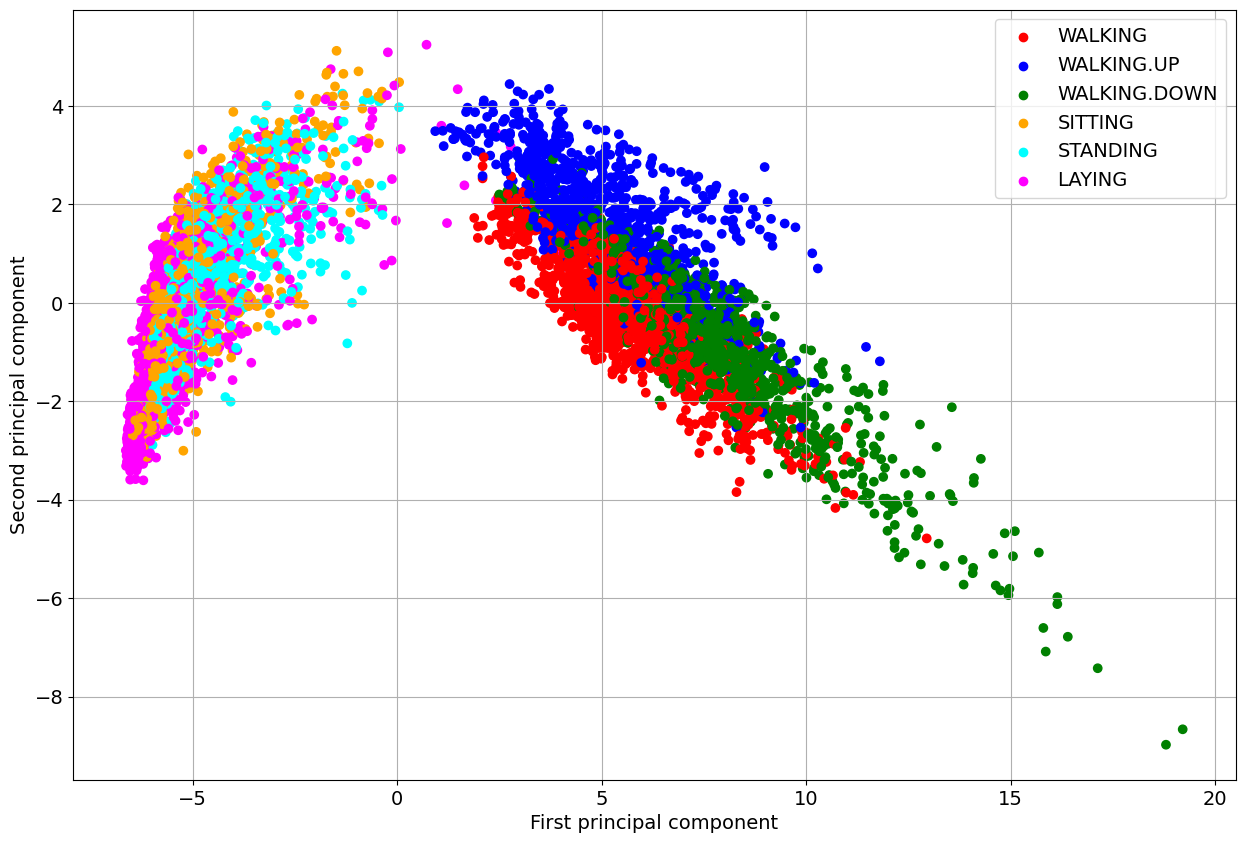

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

# Data Loaders

In [8]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [11]:
train_iter = iter(train_dataloader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([128, 128, 9])
labels shape on batch size = torch.Size([128, 1])


# GPU

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Train

In [13]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    # Инициализация списков для хранения значений потерь и точности на тренировочной и валидационной выборках
    train_loss = []  # Список для хранения среднего значения потерь на тренировочной выборке для каждого эпохи
    val_loss = []  # Список для хранения среднего значения потерь на валидационной выборке для каждой эпохи
    val_accuracy = []  # Список для хранения средней точности на валидационной выборке для каждой эпохи

    # Основной цикл по количеству эпох
    for epoch in range(n_epochs):
        ep_train_loss = []  # Список для хранения потерь на каждой итерации в текущей эпохе для тренировочной выборки
        ep_val_loss = []  # Список для хранения потерь на каждой итерации в текущей эпохе для валидационной выборки
        ep_val_accuracy = []  # Список для хранения точности на каждой итерации для валидационной выборки
        start_time = time.time()  # Запись времени начала эпохи для подсчета времени выполнения

        # Установка режима обучения для модели (активируются такие механизмы, как Dropout и BatchNorm)
        model.train(True)

        # Цикл по батчам тренировочной выборки
        for X_batch, y_batch in train_loader:
            opt.zero_grad()  # Обнуление градиентов перед обратным проходом

            X_batch = X_batch.to(device)  # Перенос входных данных на устройство (GPU или CPU)
            y_batch = y_batch.to(device)  # Перенос меток (labels) на устройство

            predictions = model(X_batch)  # Прогон входных данных через модель, получение предсказаний
            loss = loss_fn(predictions, y_batch.squeeze(1))  # Подсчет потерь (loss) между предсказаниями и реальными метками
            loss.backward()  # Обратное распространение ошибки (backpropagation) для подсчета градиентов
            opt.step()  # Обновление параметров модели на основе вычисленных градиентов

            ep_train_loss.append(loss.item())  # Сохранение значения потерь для текущей итерации

        # Установка модели в режим оценки (выключение Dropout и BatchNorm)
        model.train(False)

        # Отключение градиентов для уменьшения нагрузки на память и ускорения вычислений
        with torch.no_grad():
            # Цикл по батчам валидационной выборки
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)  # Перенос входных данных на устройство (GPU или CPU)
                y_batch = y_batch.to(device)  # Перенос меток (labels) на устройство

                predictions = model(X_batch)  # Прогон входных данных через модель, получение предсказаний
                loss = loss_fn(predictions, y_batch.squeeze(1))  # Подсчет потерь (loss) между предсказаниями и реальными метками

                ep_val_loss.append(loss.item())  # Сохранение значения потерь для текущей итерации
                y_pred = predictions.max(1)[1].data  # Определение метки класса с максимальной вероятностью
                ep_val_accuracy.append(np.mean((y_batch.squeeze(1).cpu() == y_pred.cpu()).numpy()))  # Подсчет точности предсказания для текущего батча

        # Вывод информации о текущей эпохе и времени выполнения
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        # Подсчет среднего значения потерь и точности для текущей эпохи
        train_loss.append(np.mean(ep_train_loss))  # Средняя потеря по всем батчам для тренировочной выборки
        val_loss.append(np.mean(ep_val_loss))  # Средняя потеря по всем батчам для валидационной выборки
        val_accuracy.append(np.mean(ep_val_accuracy))  # Средняя точность по всем батчам для валидационной выборки

    # Возвращение списков с потерями и точностью для каждой эпохи
    return train_loss, val_loss, val_accuracy


In [14]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    # Создание графиков с двумя подграфиками (1 строка, 2 столбца) и размером фигуры 15x5
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Настройка первого графика — отображение потерь (loss)
    axes[0].set_title('Loss')  # Установка заголовка графика
    axes[0].plot(train_loss, label='train')  # Отображение графика потерь на тренировочной выборке
    axes[0].plot(val_loss, label='validation')  # Отображение графика потерь на валидационной выборке
    axes[0].legend()  # Добавление легенды для обозначения линий (train и validation)

    # Настройка второго графика — отображение точности (accuracy) на валидационной выборке
    axes[1].set_title('Validation accuracy')  # Установка заголовка графика
    axes[1].plot(val_accuracy)  # Отображение графика точности на валидационной выборке


In [15]:
# Определение размеров входа и количества классов
input_shape = 128 * 9  # Входное количество признаков (может быть, например, развернутая матрица 128x9)
num_classes = 6  # Количество классов для предсказания (целевые метки от 0 до 5, если классы нумеруются с нуля)

# Определение архитектуры модели с использованием nn.Sequential
model = nn.Sequential(
    nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=9, stride=1, padding=0),
    # 1D-сверточный слой (Conv1d) с 128 входными каналами, 1024 выходными каналами, размером фильтра 9 и шагом 1
    nn.BatchNorm1d(1024),  # Нормализация (Batch Normalization) для ускорения обучения и уменьшения переобучения
    nn.LeakyReLU(),  # Активирующая функция Leaky ReLU для добавления нелинейности
    nn.Flatten(),  # Преобразование многомерного тензора в одномерный для передачи в полносвязные слои
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(1024, 512),  # Полносвязный слой (Linear) с 1024 входами и 512 выходами
    nn.BatchNorm1d(512),  # Нормализация (Batch Normalization) для ускорения обучения
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(512, 256),  # Полносвязный слой (Linear) с 512 входами и 256 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Dropout(0.7),  # Dropout с вероятностью 0.7 для предотвращения переобучения
    nn.Linear(256, 64),  # Полносвязный слой (Linear) с 256 входами и 64 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(64, 32),  # Полносвязный слой (Linear) с 64 входами и 32 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(32, 12),  # Полносвязный слой (Linear) с 32 входами и 12 выходами
    nn.LeakyReLU(),  # Нелинейная функция активации Leaky ReLU
    nn.Linear(12, num_classes),  # Полносвязный слой (Linear) с 12 входами и количеством выходов, равным числу классов
    nn.LogSoftmax(dim=1)  # LogSoftmax для получения логарифма вероятностей классов по выходам сети
)

# Отправка модели на устройство (GPU или CPU) и указание типа данных (float32)
model.to(device, torch.float32)

# Оптимизатор Adam для обновления параметров модели
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# Параметры модели передаются оптимизатору, а также устанавливается начальная скорость обучения (learning rate)

# Функция потерь — отрицательный логарифм правдоподобия (NLLLoss) для многоклассовой классификации
loss_func = nn.NLLLoss()
# NLLLoss ожидает логарифмированные вероятности на выходе (поэтому используется nn.LogSoftmax в конце модели)

In [16]:
n_epochs = 100

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch 1 of 100 took 8.310s
Epoch 2 of 100 took 9.823s
Epoch 3 of 100 took 10.090s
Epoch 4 of 100 took 9.214s
Epoch 5 of 100 took 9.897s
Epoch 6 of 100 took 7.882s
Epoch 7 of 100 took 9.862s
Epoch 8 of 100 took 7.788s
Epoch 9 of 100 took 9.903s
Epoch 10 of 100 took 10.427s
Epoch 11 of 100 took 8.514s
Epoch 12 of 100 took 9.539s
Epoch 13 of 100 took 7.781s
Epoch 14 of 100 took 9.970s
Epoch 15 of 100 took 7.963s
Epoch 16 of 100 took 11.132s
Epoch 17 of 100 took 9.377s
Epoch 18 of 100 took 8.497s
Epoch 19 of 100 took 9.594s
Epoch 20 of 100 took 7.858s
Epoch 21 of 100 took 10.254s
Epoch 22 of 100 took 8.171s
Epoch 23 of 100 took 10.664s
Epoch 24 of 100 took 9.216s
Epoch 25 of 100 took 8.641s
Epoch 26 of 100 took 9.698s
Epoch 27 of 100 took 8.102s
Epoch 28 of 100 took 10.033s
Epoch 29 of 100 took 8.601s
Epoch 30 of 100 took 10.592s
Epoch 31 of 100 took 8.872s
Epoch 32 of 100 took 9.056s
Epoch 33 of 100 took 9.261s
Epoch 34 of 100 took 7.970s
Epoch 35 of 100 took 9.684s
Epoch 36 of 100 took 9

accuracy:  0.9231770833333334


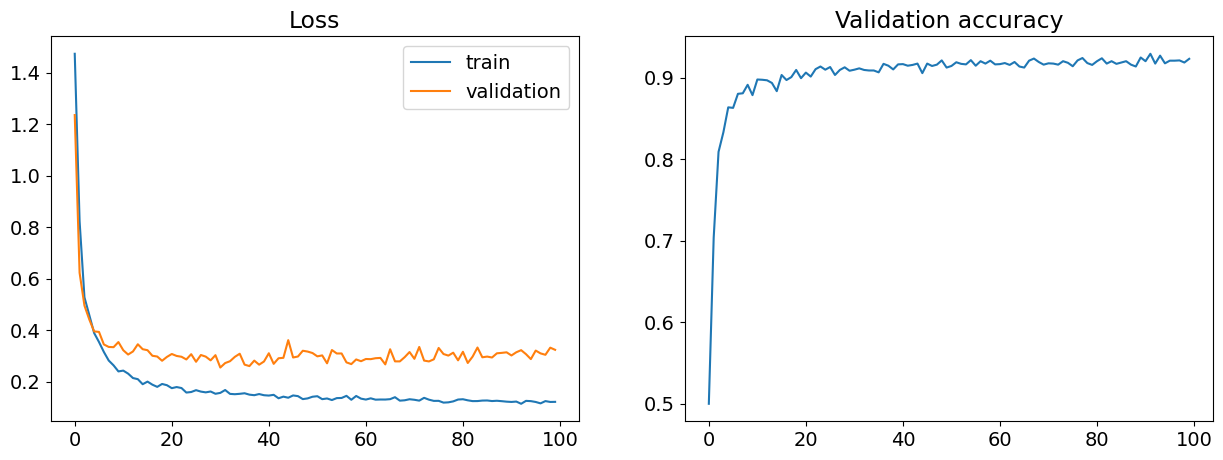

In [17]:
plot_train_process(train_loss, val_loss, val_accuracy)
print("accuracy: ", val_accuracy[-1])

Выбор архитектуры модели

Входные данные: Входной размер 128 x 9 был преобразован в одномерный вектор для удобства обработки с помощью сверточных и полносвязных слоев.

Сверточный слой (Conv1d):

Почему Conv1d? Данные представляются в виде одномерных последовательностей, и сверточные слои Conv1d эффективно извлекают локальные зависимости.
Параметры Conv1d:
in_channels=128 — количество входных каналов соответствует количеству признаков во входных данных.
out_channels=1024 — количество фильтров, увеличивающее объем представления данных.
kernel_size=9 — размер фильтра, охватывающий все 9 элементов, что позволяет учитывать зависимости по всей ширине вектора.
stride=1, padding=0 — стандартные значения для уверенного извлечения признаков.
Batch Normalization:

Почему BatchNorm1d? Нормализация входных данных на каждом слое ускоряет обучение и предотвращает переобучение.
Где используется? После каждого сверточного и полносвязного слоя для стабилизации градиентов.
Функция активации (LeakyReLU):

Почему LeakyReLU? В отличие от обычной ReLU, LeakyReLU пропускает небольшие отрицательные значения, что снижает риск возникновения "мертвых нейронов" и улучшает обучение.
Где используется? После каждого сверточного и полносвязного слоя.
Полносвязные слои (Linear):

Почему используются Linear-слои? После сверточного слоя необходимо преобразовать многомерные признаки в одномерный вектор для классификации.
Структура сети:
Сначала 1024 → 512 → 256 → 64 → 32 → 12 → 6 (где 6 — количество классов).
Снижение размерности (разреженная сеть) помогает минимизировать переобучение и улучшает обобщающую способность модели.
Dropout:

Почему Dropout? Dropout используется для случайного обнуления части нейронов с вероятностью 0.7 для борьбы с переобучением.
Где используется? После основных полносвязных слоев для регуляризации и уменьшения переобучения.
Выходной слой:

Почему LogSoftmax? Для работы с функцией потерь NLLLoss требуется, чтобы выходы были логарифмированными вероятностями.
Почему 6 выходов? Потому что задача — классификация на 6 классов, и выходная размерность соответствует количеству классов.
Оптимизатор и функции потерь

Оптимизатор Adam:

Почему Adam? Этот оптимизатор адаптивно подбирает скорость обучения для каждого параметра, что ускоряет сходимость.
Начальная скорость обучения (learning rate = 1e-3) — выбрано эмпирически как стандартное значение для многих задач.
Функция потерь NLLLoss:

Почему NLLLoss? Поскольку последний слой использует LogSoftmax, наиболее подходящей функцией потерь является NLLLoss, которая работает с логарифмом вероятностей.
Почему именно NLLLoss, а не CrossEntropyLoss? CrossEntropyLoss объединяет Softmax и NLLLoss, но так как мы отдельно используем LogSoftmax, то NLLLoss — правильный выбор.
Преимущества выбранного подхода

Устойчивость к переобучению:

Использование Dropout и Batch Normalization делает сеть устойчивой к переобучению.
Эффективность и скорость сходимости:

LeakyReLU устраняет проблему "мертвых нейронов", делая обучение более устойчивым.
Adam ускоряет обучение за счет адаптивной скорости обучения для каждого параметра.
Гибкость и масштабируемость:

Архитектура легко расширяется под другие задачи классификации (достаточно изменить размер выходного слоя и число классов).
Использование стандартных подходов (BatchNorm, Dropout) делает обучение стабильным и переносимым на другие наборы данных.
Возможные улучшения
Добавить scheduler — использование scheduler для адаптивного изменения скорости обучения. Например, можно уменьшать learning rate каждые 10 эпох.
Провести кросс-валидацию — для оценки устойчивости модели на различных подвыборках данных.
Увеличить количество фильтров в сверточных слоях для извлечения большего количества признаков.
Добавить больше регуляризации — можно уменьшить p в Dropout, чтобы меньше нейронов обнулялось.